# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [314]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/var/folders/4x/pds2gxg17h57rrp30d736s1w0000gn/T/ipykernel_47033/2889067548.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [315]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

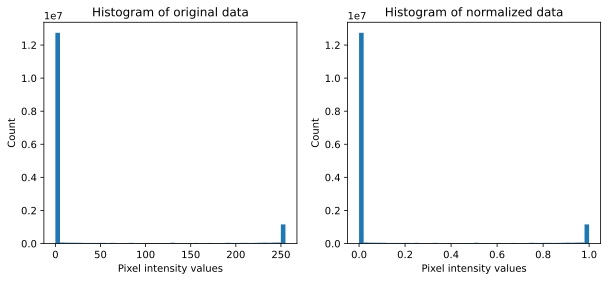

In [316]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

# Create train/test groups using DataLoader

In [317]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [318]:
# check all variables in workspace
%whos

Variable                 Type             Data/Info
---------------------------------------------------
C                        ndarray          2126x2126: 4519876 elems, type `float64`, 36159008 bytes (34.483917236328125 Mb)
DataLoader               type             <class 'torch.utils.data.dataloader.DataLoader'>
F                        module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset            type             <class 'torch.utils.data.dataset.TensorDataset'>
X                        Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
a                        Tensor           tensor([[7.1623e-11, 3.09<...>,\n         1.9711e-08]])
almostError7             list             n=9
almostErrorK             list             n=15
aveAll7s                 ndarray          28x28: 784 elems, type `float64`, 6272 bytes
aveAllCorrect7s          Tensor           tensor([[0.0000e+00, 0.00<...>0.0000e+00, 0.0000e+00]])
aveAllCorrectis    

# Create the DL model

In [319]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [320]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.sum(torch.exp(yHat),axis = 1))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3107, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [321]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [322]:
trainAcc,testAcc,losses,net = function2trainTheModel()


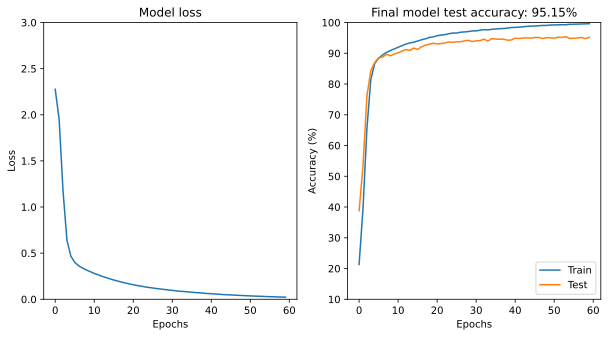

In [323]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [324]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-2.0918e+01, -2.2106e+01, -3.5740e+01,  ..., -3.9820e+01,
         -1.6887e+01, -2.8249e+01],
        [-2.4028e+01, -6.9895e+00, -1.1178e+01,  ..., -1.3011e+01,
         -1.0518e+01, -1.3008e+01],
        [-1.3890e+01, -7.1342e+00, -1.8739e+01,  ..., -1.5220e+01,
         -5.6195e+00, -1.3850e+01],
        ...,
        [-2.0717e+01, -1.8663e+01, -2.4441e+01,  ..., -1.9060e+01,
         -1.0768e+01, -9.7011e+00],
        [-1.0975e+00, -1.6127e+01, -7.2490e+00,  ..., -1.7027e+01,
         -4.6032e+00, -1.2674e+01],
        [-2.5034e-06, -4.3309e+01, -1.2897e+01,  ..., -2.6465e+01,
         -1.8648e+01, -1.7260e+01]])

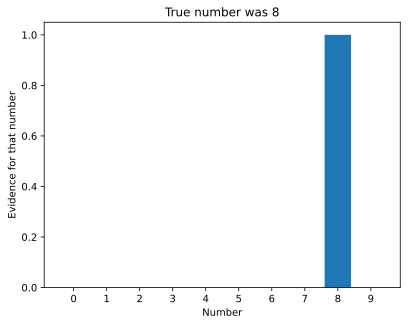

In [325]:
# Evidence for all numbers from one sample
sample2show = 271

plt.bar(range(10),torch.exp(predictions[sample2show])) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

In [326]:
np.where( torch.max(predictions,axis=1)[1] != y )[0]

array([  85,   91,  101,  158,  207,  212,  241,  244,  249,  252,  290,
        297,  371,  400,  415,  429,  446,  458,  459,  479,  496,  525,
        527,  604,  667,  674,  695,  709,  717,  718,  726,  749,  778,
        811,  851,  866,  878,  879,  942,  957,  958,  978, 1009, 1026,
       1029, 1078, 1084, 1102, 1125, 1131, 1133, 1148, 1166, 1187, 1194,
       1201, 1234, 1251, 1300, 1309, 1328, 1329, 1358, 1402, 1408, 1414,
       1427, 1464, 1475, 1477, 1482, 1522, 1604, 1683, 1707, 1708, 1725,
       1743, 1749, 1750, 1752, 1753, 1763, 1772, 1781, 1783, 1785, 1793,
       1802, 1818, 1828, 1884, 1892, 1916, 1917, 1960, 1972])

[  85   91  101  158  207  212  241  244  249  252  290  297  371  400
  415  429  446  458  459  479  496  525  527  604  667  674  695  709
  717  718  726  749  778  811  851  866  878  879  942  957  958  978
 1009 1026 1029 1078 1084 1102 1125 1131 1133 1148 1166 1187 1194 1201
 1234 1251 1300 1309 1328 1329 1358 1402 1408 1414 1427 1464 1475 1477
 1482 1522 1604 1683 1707 1708 1725 1743 1749 1750 1752 1753 1763 1772
 1781 1783 1785 1793 1802 1818 1828 1884 1892 1916 1917 1960 1972]


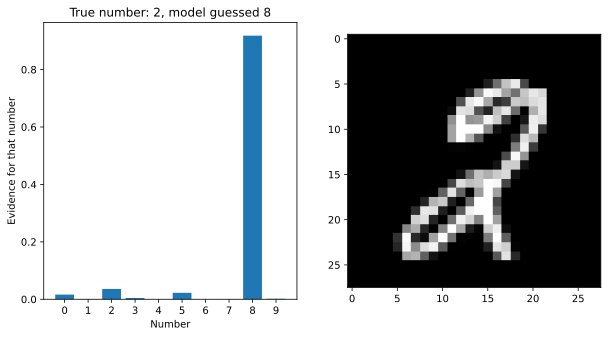

In [327]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 17

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

In [328]:
torch.max(predictions,axis=1)[1]

tensor([5, 3, 5,  ..., 4, 6, 0])

In [329]:
torch.max(predictions,axis=1)[0][0]

tensor(0.)

In [330]:
errors7 = np.where( (torch.max(predictions,axis=1)[1] != y) & (y == 7) )[0]
correct7 = np.where( (torch.max(predictions,axis=1)[1] == y) & (y == 7) )[0]
for err in errors7:
    print(torch.argmax(predictions[err]).item())

2
3
9
9
3
1
2
5
4


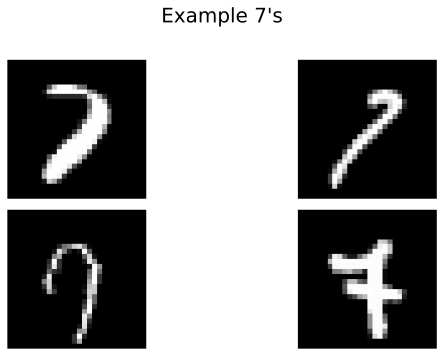

In [331]:
# plotting original images corresponding to first 4 incorrect predictions of 7
fig,axs = plt.subplots(2,2,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  img = np.reshape(X[errors7[i],:],(28,28))
  ax.imshow(img,cmap='gray')
  ax.axis('off')

plt.suptitle("Example 7's",fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

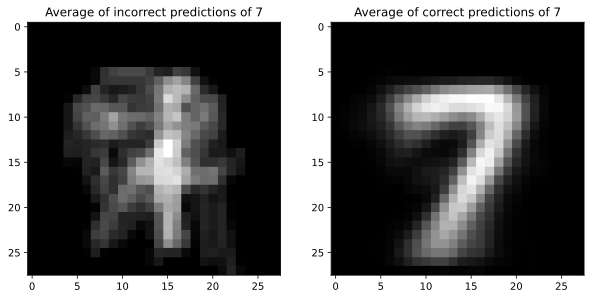

In [332]:
# Plotting original images corresponding to correct and incorrect predictions of 7
fig,ax = plt.subplots(1,2,figsize=(10,5))
aveAllError7s = torch.mean(X[errors7],axis = 0).reshape(28,28)
aveAllCorrect7s = torch.mean(X[correct7],axis = 0).reshape(28,28)
ax[0].imshow(aveAllError7s,cmap='gray')
ax[0].set_title("Average of incorrect predictions of 7")
ax[1].imshow(aveAllCorrect7s,cmap='gray')
ax[1].set_title("Average of correct predictions of 7")
plt.show()

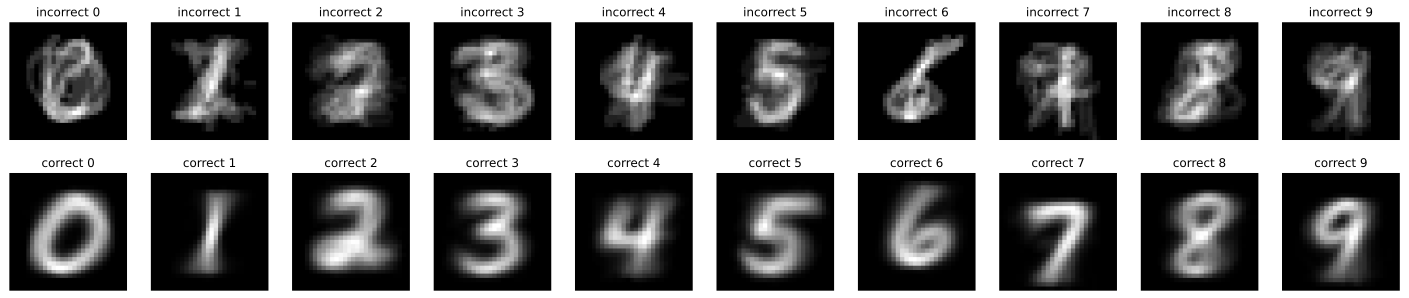

In [333]:
# Plotting original images corresponding to correct and incorrect predictions of all 10 digits
fig,ax = plt.subplots(2,10,figsize=(25,5))
for i in range(10):
    errorsi = np.where( (torch.max(predictions,axis=1)[1] != y) & (y == i) )[0]
    correcti = np.where( (torch.max(predictions,axis=1)[1] == y) & (y == i) )[0]
    aveAllErroris = torch.mean(X[errorsi],axis = 0).reshape(28,28)
    aveAllCorrectis = torch.mean(X[correcti],axis = 0).reshape(28,28)
    ax[0,i].imshow(aveAllErroris,cmap='gray')
    ax[0,i].set_title(f'incorrect {i}')
    ax[1,i].imshow(aveAllCorrectis,cmap='gray')
    ax[1,i].set_title(f'correct {i}')
    ax[0,i].axis('off')
    ax[1,i].axis('off')
plt.show()

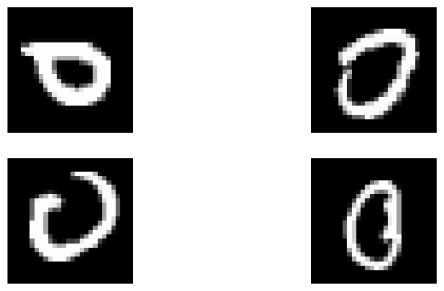

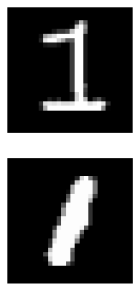

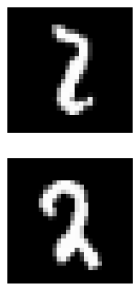

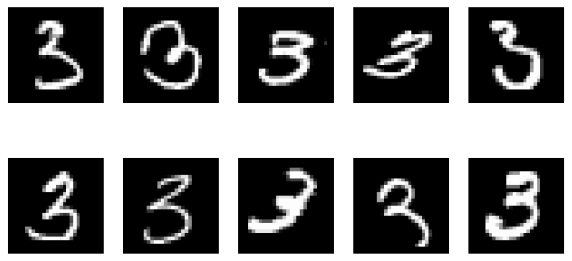

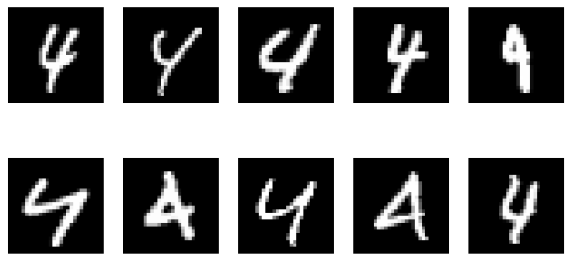

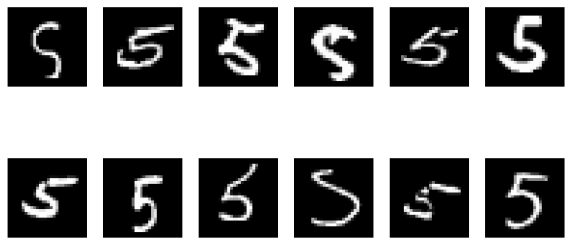

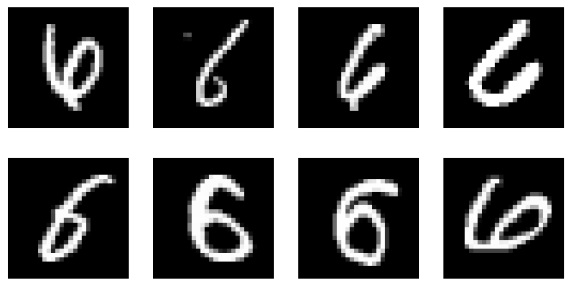

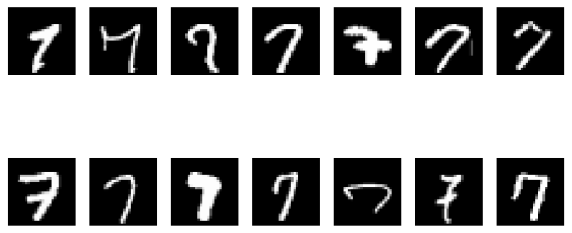

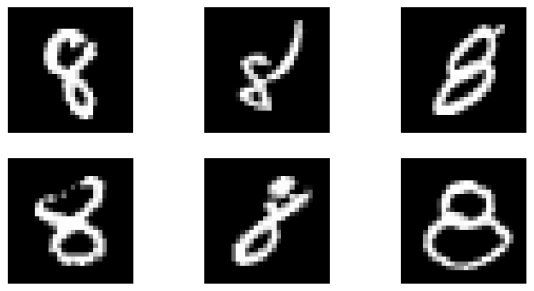

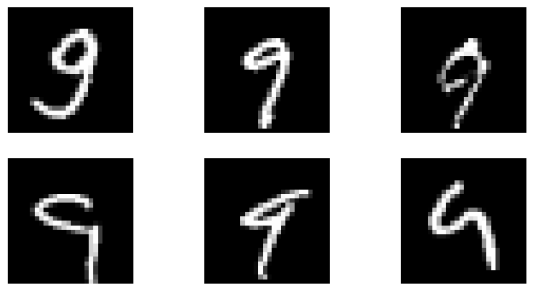

In [334]:
# plotting almost errors for all 10 digits 
expPredictions = torch.exp(predictions)
closePredictions = []
for i,row in enumerate(expPredictions):
    count = torch.numel(row[row>0.1])
    if count>1:
        closePredictions.append(i)

for k in range(10):
    correctK = np.where( (torch.max(predictions,axis=1)[1] == y) & (y == k) )[0]
    almostErrorK = [i for i in correctK if i in closePredictions]
    fig,axs = plt.subplots(2,len(almostErrorK)//2,figsize=(10,5))
    
    for i,ax in enumerate(axs.flatten()):
      img = np.reshape(X[almostErrorK[i],:],(28,28))
      ax.imshow(img,cmap='gray')
      ax.axis('off')

    plt.show()

# Additional explorations

In [335]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# MY COMMENTS: Coded inline
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# MY COMMENTS: Coded inline
#
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# MY COMMENTS: Coded inline
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# MY COMMENTS: Not a problem because we are not using DROPOUT in model architecture